In [79]:
from utils import *
from scipy.stats import qmc
from scipy.stats import spearmanr
from scipy import optimize
import os
import pandas as pd

In [83]:
def runner(
    fried_num, 
    noise, 
    norm,
    c_val_bounds, 
    ntk_depth, 
    ansiotropic,
    white,
    w_fixed=False,
    alpha=False,
    opt_bounds = [0.0001, 10],
    opt_resets = 10,
    figs = False,
    diagnostic = False,
    exp_name = ''
    ):

    if type(ntk_depth) == int:
        ntk_depth = (ntk_depth,)

    return_vals = {
        'Dataset' : f'Friedman {fried_num}',
        'Noise': False if noise == 0.0 else True,
        'Norm' : norm,
        'Constant Value Bounds' : 'fixed' if c_val_bounds == 'fixed' else 'unfixed',
        'White/Bounds/Alpha' : (white, w_fixed, alpha)
        }
    print(
        f"Friedman {fried_num}, Noise: {noise}, Norm: {norm}, cv_bounds: {c_val_bounds}, white/bounds/alpha: {white, w_fixed, alpha}"
    )

    # dir level:
    # exp
    #   Dataset
    #       plots

    job_name = f"Pred_N{noise}_N_{norm}_c{return_vals['Constant Value Bounds']}_ans_{ansiotropic}_w_{white}_w_fixed_{w_fixed}_alp_{alpha}"

    exp_name = os.path.join(os.getcwd(), 'experiments', exp_name, f'F{fried_num}')
    if not os.path.isdir(exp_name):
        os.makedirs(exp_name)

    opt_lower, opt_upper = opt_bounds

    arrsize=30
    # Datasets
    if fried_num==1:
        # Ackley function
        tmp = np.linspace(-3,3, arrsize)
        X, Y = np.meshgrid(tmp, tmp)    
        Z = -20*np.exp(-0.2 * np.sqrt(0.5*(X**2 + Y**2))) - np.exp(0.5 *(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))) + np.e + 20
    elif fried_num==2:
        tmp = np.linspace(0,1, arrsize)
        X, Y = np.meshgrid(tmp, tmp)    
        # Franke's function
        Z = (0.75*np.exp(- (9*X - 2)**2/4 - (9*Y - 2)**2/4) + 
             0.75*np.exp(- (9*X + 1)**2/49 - (9*Y + 1)/10) +
             0.5*np.exp(- (9*X - 7)**2/4  - (9*Y - 3)**2/4) +
             0.2*np.exp(- (9*X - 4)**2    - (9*Y - 7)**2))
    elif fried_num==3:
        tmp = np.linspace(0,1, arrsize)
        X, Y = np.meshgrid(tmp, tmp)  
        # Lim et al. nonpolynomial function
        Z = 1/6 * ((30+5*X*np.sin(5*X))*(4+np.exp(-5*Y)) - 100)
    else:
        return Exception("fried_num must be either 1, 2, or 3")
    
    bigX = np.stack((X,Y), axis=2).reshape(-1,2)
    smolY = Z.reshape(-1,1)
    datasets = processing(bigX, smolY, noise = noise)

    # Setting orig train 2 which is y_train_noisy because noise can ==0
    X, y, X_train, y_train = [None, datasets['orig'][1], None, datasets['orig train'][2]]

    if norm:
        X = datasets['norm'][0]
        X_train = datasets['norm train'][0]
    else:
        X = datasets['orig'][0]
        X_train = datasets['orig train'][0]



    # Lengthscale Optimization
    def g(ell, gp, mean_ntk, typ):
        try:
            gp.set_params(**{'kernel__k2__length_scale': ell})
        except:
            gp.set_params(**{'kernel__k1__k2__length_scale': ell})

        gp.fit(X_train, y_train)
        mean = gp.predict(X)

        if diagnostic == True:
            print(typ, gp.kernel_)

        return np.sqrt(np.mean((mean_ntk - mean)**2))

    for depth in ntk_depth:
        # Kernels
        if noise != 0.0 and white == True and alpha == False:
            ntk = (
                ConstantKernel(
                    constant_value=1,
                    constant_value_bounds=c_val_bounds
                ) *
                NTK(depth=depth, c=2,
                    bias=1e-1,
                    bias_bounds=(1e-9, 1e3)
                ) + 
                WhiteKernel(
                    noise_level=0.15**2, 
                    noise_level_bounds='fixed' if w_fixed else (1e-4, 0.5))#(0.001, 1))
            )
        else:
            ntk = (
                ConstantKernel(
                    constant_value=1,
                    constant_value_bounds=c_val_bounds#(1e-9, 1e2)
                ) *
                NTK(depth=depth, c=2,
                    bias=1e-1,
                    bias_bounds=(1e-9, 1e3)
                )
            )

        gp_ntk = GPR(kernel=ntk, alpha=1e-5 if not alpha else 0.15**2, normalize_y=True,
                    n_restarts_optimizer=9, random_state=3480795)
        gp_ntk.fit(X_train, y_train)
        print(f'NTK {depth} : ', gp_ntk.kernel_)
        mean_ntk = gp_ntk.predict(X)
        
        # print(gp_ntk.kernel_.get_params())


        if noise != 0.0 and white == True:
            lpk = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'],
                    constant_value_bounds='fixed'
                ) *
                Matern(
                    nu=1/2,
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000) 
                                        for i in range(0, X.shape[1])]) if ansiotropic else 1,
                    length_scale_bounds='fixed'
                ) + 
                WhiteKernel(
                    noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'], 
                    noise_level_bounds='fixed')
            )
        else:
            lpk = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
                    constant_value_bounds='fixed'
                ) *
                Matern(
                    nu=1/2,
                    # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                        for i in range(0, X.shape[1])]) if ansiotropic else 1,
                    length_scale_bounds='fixed'
                )
            )

        gp_lpk = GPR(kernel=lpk, alpha=1e-5 if not alpha else 0.15**2, normalize_y=True,
                    n_restarts_optimizer=0, random_state=3480795)

        if ansiotropic:
            ell_lpk = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]), args=(
                gp_lpk, mean_ntk, f'LPK {depth}:'), 
                bounds=tuple((0.00001, 10) for n in range(0, X.shape[1])))
            for i in range(0, opt_resets):
                tmp = optimize.minimize(g, np.array([[np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]]), args=(
                    gp_lpk, mean_ntk, f'LPK {depth}:'), 
                    bounds=tuple((0.00001, 10**i) for n in range(0, X.shape[1])))
                if tmp.fun < ell_lpk.fun:
                    ell_lpk = tmp

        else:
            ell_lpk = optimize.minimize_scalar(g, args=(
                gp_lpk, mean_ntk, f'LPK {depth}:'), 
                method='bounded', bounds=opt_bounds, options={'maxiter': 10000})
            # for i in range(0, opt_resets):
            #     tmp = optimize.minimize_scalar(g, args=(
            #         gp_lpk, mean_ntk, f'LPK {depth}:'),
            #         method='bounded', bounds=[opt_lower, opt_upper*(10**i)], options={'maxiter': 10000})
            #     if tmp.fun < ell_lpk.fun:
            #         ell_lpk = tmp

        try:
            gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
        except:
            gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
        gp_lpk.fit(X_train, y_train)
        mean_lpk_opt = gp_lpk.predict(X)
        print(gp_lpk.kernel_)


        #################################
        # Begin gathering return values #
        #################################
        return_vals[f'x_lpk_{depth}'] = ell_lpk.x
        return_vals[f'f_lpk_{depth}'] = ell_lpk.fun
        return_vals[f'Pcorr_lpk_{depth}_res'] = np.corrcoef((y-mean_ntk)[:,0], (y-mean_lpk_opt)[:,0])[0, 1]
        return_vals[f'Pcorr_lpk_{depth}_y'] = np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1]
        corr_lpk_res = return_vals[f'Pcorr_lpk_{depth}_res']
        corr_lpk_y   = return_vals[f'Pcorr_lpk_{depth}_y']



        if norm:
            if noise != 0.0 and white == True and alpha == False:
                rbf = (
                    ConstantKernel(
                        constant_value=1, 
                        constant_value_bounds=c_val_bounds
                    ) * 
                    Matern(
                        nu=np.inf,
                        length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                               for i in range(0, X.shape[1])]) if ansiotropic else 1,
                        length_scale_bounds='fixed'
                    ) + 
                    WhiteKernel(
                        noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
                        noise_level_bounds='fixed'
                    )
                )
            else:
                rbf = (
                    ConstantKernel(
                        constant_value=1,
                        constant_value_bounds=c_val_bounds
                    ) *
                    Matern(
                        nu=np.inf,
                        length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                               for i in range(0, X.shape[1])]) if ansiotropic else 1,
                        length_scale_bounds='fixed'
                    )
                )

            gp_rbf = GPR(kernel=rbf, alpha=1e-9 if not alpha else 0.15**2, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

            if ansiotropic:
                ell_rbf = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]), args=(
                    gp_rbf, mean_ntk, f'RBF {depth}:'), 
                    bounds=tuple((0.00001, 10) for n in range(0, X.shape[1])))
                for i in range(0, opt_resets):
                    tmp = optimize.minimize(g, np.array([[np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]]), args=(
                        gp_rbf, mean_ntk, f'RBF {depth}:'), 
                        bounds=tuple((0.00001, 10**i) for n in range(0, X.shape[1])))
                    if tmp.fun < ell_rbf.fun:
                        ell_rbf = tmp

            else:
                ell_rbf = optimize.minimize_scalar(g, args=(
                    gp_rbf, mean_ntk, f'RBF {depth}:'), 
                    method='bounded', bounds=opt_bounds, options={'maxiter': 10000})
                # for i in range(0, opt_resets):
                #     tmp = optimize.minimize_scalar(g, args=(
                #         gp_rbf, mean_ntk, f'RBF {depth}:'),
                #         method='bounded', bounds=[opt_lower, opt_upper*(10**i)], options={'maxiter': 10000})
                #     if tmp.fun < ell_rbf.fun:
                #         ell_rbf = tmp

            try:
                gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
            except:
                gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
            gp_rbf.fit(X_train, y_train)
            mean_rbf_opt = gp_rbf.predict(X)
            print(gp_rbf.kernel_)



            ####################################
            # Continue gathering return values #
            ####################################
            return_vals[f'x_rbf_{depth}'] = ell_rbf.x
            return_vals[f'f_rbf_{depth}'] = ell_rbf.fun
            return_vals[f'Pcorr_rbf_{depth}_res'] = np.corrcoef((y-mean_ntk)[:,0], (y-mean_rbf_opt)[:,0])[0, 1]
            return_vals[f'Pcorr_rbf_{depth}_y'] = np.corrcoef((mean_ntk)[:,0], (mean_rbf_opt)[:,0])[0, 1]
            corr_rbf_res = return_vals[f'Pcorr_rbf_{depth}_res']
            corr_rbf_y = return_vals[f'Pcorr_rbf_{depth}_y']



        if figs:
            print("Creating plots...")
            plt.ioff()
            funcs = os.path.join(exp_name, 'plots')
            if not os.path.isdir(funcs):
                os.makedirs(funcs)

            nrows = 2 if norm else 1
            ncols = 2 if norm else 3

            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8 if norm else 10, 8 if norm else 6))
            axes = axes.ravel()
            for i in range(0, len(axes)):
                axes[i].remove()
                axes[i] = plt.subplot(nrows, ncols, i+1, projection='3d')
                axes[i].patch.set_alpha(0)
                if i == 0 : plt.title('Data')
                if norm:
                    if i == 1 : plt.title('RBF')
                    if i == 2 : plt.title('NTK')
                    if i == 3 : plt.title('LPK')                    
                else:
                    if i == 1 : plt.title('NTK')
                    if i == 2 : plt.title('LPK')

            
            axes[0].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),y.reshape(-1,arrsize), levels=150)

            if norm:
                axes[1].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),mean_rbf_opt.reshape(-1,arrsize), levels=150)
                axes[2].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),mean_ntk.reshape(-1,arrsize), levels=150)
                axes[3].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),mean_lpk_opt.reshape(-1,arrsize), levels=150)
            else:
                axes[1].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),mean_ntk.reshape(-1,arrsize), levels=150)
                axes[2].contourf(X[:,0].reshape(-1,arrsize),X[:,1].reshape(-1,arrsize),mean_lpk_opt.reshape(-1,arrsize), levels=150)                

            
            fig.tight_layout()
            fig.savefig(f'{funcs}/depth_{depth}_{job_name}.png', dpi=150, transparent=False, bbox_inches='tight')
            plt.ion()

    return return_vals

Friedman 1, Noise: 0.0, Norm: True, cv_bounds: (1e-05, 1000.0), white/bounds/alpha: (False, False, False)
NTK 3 :  0.0355**2 * NTK(depth=3, c=2.000, bias=4.312)
0.0355**2 * Matern(length_scale=1.76, nu=0.5)


/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1e+03. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1e+03. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1e+03. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gau

31.6**2 * Matern(length_scale=0.101, nu=inf)
Creating plots...


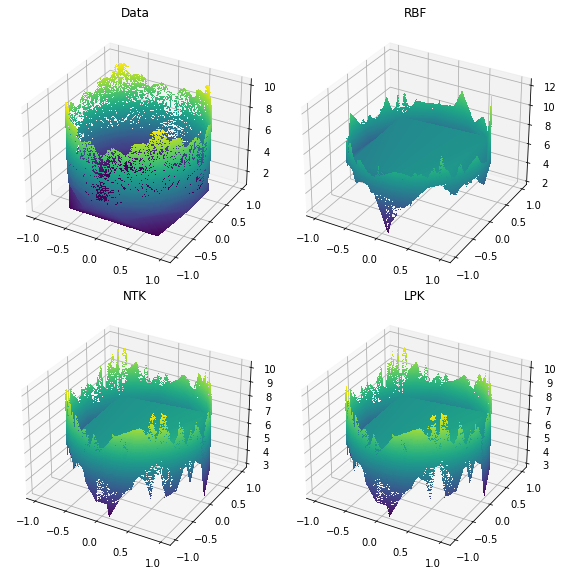

In [77]:
# %%capture
# fried_num, 
# noise, 
# norm,
# c_val_bounds, 
# ntk_depth, 
# ansiotropic,
# white,
# w_fixed=False,
# alpha=False,
# opt_bounds = [0.0001, 10],
# opt_resets = 10,
# figs = False,
# diagnostic = False,
# exp_name = ''
depths=3
params = [
    [1, 0.0, True, (1e-5, 1e3)],
    # [2, 0.15, False, 'fixed', 'p']
]

kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': False, 'alpha': False, 'w_fixed': False, 'opt_bounds': [0.0001, 10], 'opt_resets': 10, 'diagnostic': False, 'figs': True, 'exp_name': 'diagnostic'}

test = []
for param in params:
    test.append(runner(*param, **kparams))

In [84]:
params = [
    #fried_num  noise   norm c_val_bounds  
    # [        1,   0.0, False,      'fixed'], # 0
    [        1,   0.0, False,  (1e-9, 1e5)], # 1
    # [        1,   0.0,  True,      'fixed'], # 2
    [        1,   0.0,  True,  (1e-9, 1e5)], # 3
    # [        1,  0.15, False,      'fixed'], # 4 
    [        1,  0.15, False,  (1e-9, 1e5)], # 5
    # [        1,  0.15,  True,      'fixed'], # 6
    [        1,  0.15,  True,  (1e-9, 1e5)], # 7
    
    # [        1,   0.0, False,      'fixed'], # 8
    [        1,   0.0, False,  (1e-9, 1e5)], # 9
    # [        1,   0.0,  True,      'fixed'], # 10
    [        1,   0.0,  True,  (1e-9, 1e5)], # 11
    # [        1,  0.15, False,      'fixed'], # 12
    [        1,  0.15, False,  (1e-9, 1e5)], # 13
    # [        1,  0.15,  True,      'fixed'], # 14
    [        1,  0.15,  True,  (1e-9, 1e5)], # 15


    # [        2,   0.0, False,      'fixed'], # 16
    [        2,   0.0, False,  (1e-9, 1e5)], # 17
    # [        2,   0.0,  True,      'fixed'], # 18
    [        2,   0.0,  True,  (1e-9, 1e5)], # 19
    # [        2,  0.15, False,      'fixed'], # 20
    [        2,  0.15, False,  (1e-9, 1e5)], # 21
    # [        2,  0.15,  True,      'fixed'], # 22
    [        2,  0.15,  True,  (1e-9, 1e5)], # 23

    # [        2,   0.0, False,      'fixed'], # 24
    [        2,   0.0, False,  (1e-9, 1e5)], # 25
    # [        2,   0.0,  True,      'fixed'], # 26
    [        2,   0.0,  True,  (1e-9, 1e5)], # 27
    # [        2,  0.15, False,      'fixed'], # 28
    [        2,  0.15, False,  (1e-9, 1e5)], # 29
    # [        2,  0.15,  True,      'fixed'], # 30
    [        2,  0.15,  True,  (1e-9, 1e5)], # 31


    # [        3,   0.0, False,      'fixed'], # 32
    [        3,   0.0, False,  (1e-9, 1e5)], # 33
    # [        3,   0.0,  True,      'fixed'], # 34
    [        3,   0.0,  True,  (1e-9, 1e5)], # 35
    # [        3,  0.15, False,      'fixed'], # 36
    [        3,  0.15, False,  (1e-9, 1e5)], # 37
    # [        3,  0.15,  True,      'fixed'], # 38
    [        3,  0.15,  True,  (1e-9, 1e5)], # 39
    
    # [        3,   0.0, False,      'fixed'], # 40
    [        3,   0.0, False,  (1e-9, 1e5)], # 41
    # [        3,   0.0,  True,      'fixed'], # 42
    [        3,   0.0,  True,  (1e-9, 1e5)], # 43
    # [        3,  0.15, False,      'fixed'], # 44
    [        3,  0.15, False,  (1e-9, 1e5)], # 45
    # [        3,  0.15,  True,      'fixed'], # 46
    [        3,  0.15,  True,  (1e-9, 1e5)], # 47
]


In [89]:
depths=(3,25)
arrays_lpk = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [False, True],  # Norm
    [False, True],  # Noise
    depths,
    # ['fixed', 'unfixed']
]

arrays_rbf = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [False, True],  # Noise
    depths,
    # ['fixed', 'unfixed']
]

index_lpk = pd.MultiIndex.from_product(
    arrays_lpk, names=["Dataset", "Norm", "Noise", "Depth"])

index_rbf = pd.MultiIndex.from_product(
    arrays_rbf, names=["Dataset", "Noise", "Depth"])


df_lpk = pd.DataFrame(
    index=index_lpk,
    columns=['X', 'f(X)', 'Residual Correlation', 'Prediction Correlation'])

df_rbf = pd.DataFrame(
    index=index_rbf,
    columns=['X', 'f(X)', 'Residual Correlation', 'Prediction Correlation'])


In [86]:
%%capture
kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': True, 'w_fixed': False, 'alpha': False, 'figs': True, 'exp_name': 'complex'}
results = []
for param in params:
    results.append(runner(*param, **kparams))

In [90]:
for out in results:
    for depth in depths:

        df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],    depth), 
                    "X"] = out['x_lpk_' + str(depth)]
        df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],  depth), 
                    "f(X)"] = out['f_lpk_' + str(depth)]

        df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],    depth), 
                    "Residual Correlation"] = out[f'Pcorr_lpk_{depth}_res']

        df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],  depth), 
                    "Prediction Correlation"] = out[f'Pcorr_lpk_{depth}_y']

        if out["Norm"] == True:
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
                        "X"] = out['x_rbf_' + str(depth)]
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
                        "f(X)"] = out['f_rbf_' + str(depth)]

            df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
                        "Residual Correlation"] = out[f'Pcorr_rbf_{depth}_res']
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
                        "Prediction Correlation"] = out[f'Pcorr_rbf_{depth}_y']

In [93]:
print(df_lpk.to_latex())

\begin{tabular}{llllllll}
\toprule
           &      &      &    &         X &      f(X) & Residual Correlation & Prediction Correlation \\
Dataset & Norm & Noise & Depth &           &           &                      &                        \\
\midrule
Friedman 1 & False & False & 3  &  0.004044 &  1.890239 &             0.624108 &                0.42638 \\
           &      &      & 25 &   0.00399 &  1.897534 &             0.627331 &               0.425584 \\
           &      & True & 3  &  9.999995 &  0.051485 &             0.999994 &               0.987777 \\
           &      &      & 25 &  9.999995 &  0.048551 &             0.999993 &               0.963194 \\
           & True & False & 3  &  9.999922 &  0.040039 &             0.999787 &               0.999631 \\
           &      &      & 25 &   0.12307 &  0.001803 &                  1.0 &               0.999999 \\
           &      & True & 3  &  1.759539 &  0.016152 &              0.99996 &                0.99943 \\
       

/tmp/ipykernel_15335/1952679750.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_lpk.to_latex())


In [94]:
print(df_rbf.to_latex())

\begin{tabular}{lllllll}
\toprule
           &      &    &         X &      f(X) & Residual Correlation & Prediction Correlation \\
Dataset & Noise & Depth &           &           &                      &                        \\
\midrule
Friedman 1 & False & 3  &  0.093022 &  1.004069 &             0.861193 &                0.73512 \\
           &      & 25 &  0.132322 &  1.105407 &             0.823629 &               0.653373 \\
           & True & 3  &  0.229555 &   0.07085 &             0.999265 &               0.988202 \\
           &      & 25 &  0.101558 &  0.134561 &             0.997397 &               0.967682 \\
Friedman 2 & False & 3  &  9.999967 &  0.215844 &             0.692363 &               0.223674 \\
           &      & 25 &  9.999974 &  0.215831 &             0.692389 &               0.223665 \\
           & True & 3  &  1.840157 &  0.072029 &             0.964684 &               0.570762 \\
           &      & 25 &  1.840157 &  0.075639 &             0.960991 & 

/tmp/ipykernel_15335/791458903.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_rbf.to_latex())


# Dataset

In [61]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sqrt(np.mean((mean_ntk - mean)**2))

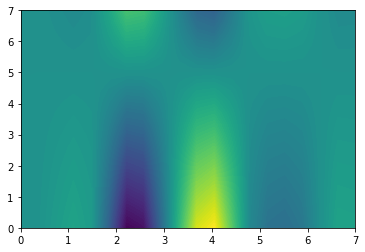

In [2]:
arrsize=20
tmp = np.linspace(0, 7, arrsize, dtype=np.float16)
X, Y = np.meshgrid(tmp, tmp)
Z = np.exp(-X)*X**3*np.cos(X)*np.sin(X)*(np.cos(X)*np.sin(X)**2-1)*(Y-5)
plt.contourf(X, Y, Z, levels=100)

bigX = np.stack((X, Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)

bigX_norm = normalize(bigX, axis=1)

datasets = processing(bigX, smolY, noise = 0.15)
X, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']


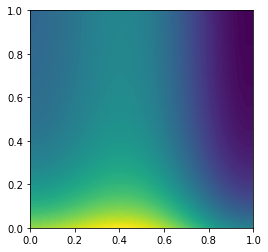

In [31]:
arrsize=30
tmp = np.linspace(0,1, arrsize)
X, Y = np.meshgrid(tmp, tmp)
Z = 1/6 * ((30+5*X*np.sin(5*X))*(4+np.exp(-5*Y)) - 100)

bigX = np.stack((X,Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(X,Y,Z, levels=100)
bigX_norm = normalize(bigX)

datasets = processing(bigX, smolY, noise = 0.15)
X, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']


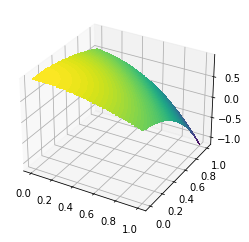

In [115]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.remove()
ax = plt.axes(projection='3d')
ax.contourf(X,Y,Z, levels=100)

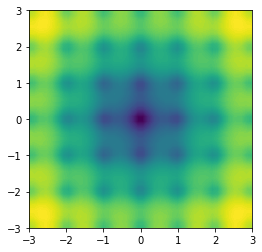

In [62]:
arrsize=40
tmp = np.linspace(-3,3, arrsize)
X, Y = np.meshgrid(tmp, tmp)
Z = -20*np.exp(-0.2 * np.sqrt(0.5*(X**2 + Y**2))) - np.exp(0.5 *(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))) + np.e + 20

bigX = np.stack((X,Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)


datasets = processing(bigX, smolY, noise = 0.15)
X_orig, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']

data = (X_train, y_train, X_orig, y)
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(X,Y,Z, levels=100)

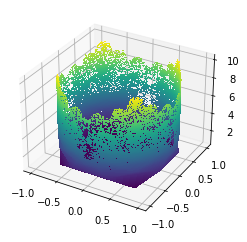

In [63]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.remove()
ax = plt.axes(projection='3d')
plt.contourf(X_norm[:,0].reshape(-1,40),X_norm[:,1].reshape(-1,40),Z, levels=150)
# plt.contour(X,Y,Z, levels=100)

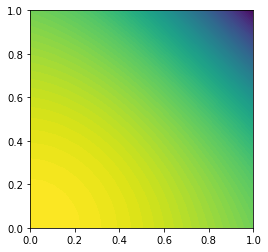

In [79]:
arrsize=20
tmp = np.linspace(0,1, arrsize)
X, Y = np.meshgrid(tmp, tmp)
Z = np.cos(X + Y)*np.exp(X*Y)

bigX = np.stack((X,Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(X,Y,Z, levels=100)
bigX_norm = normalize(bigX)

datasets = processing(bigX, smolY, noise = 0.15)
X_orig, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']

data = (X_train, y_train, X_orig, y)

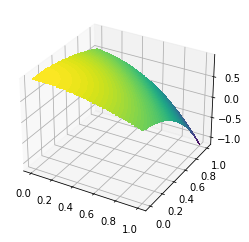

In [80]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.remove()
ax = plt.axes(projection='3d')
plt.contourf(X,Y,Z, levels=100)

In [64]:
ntk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e3)
    )
    + 
    WhiteKernel(noise_level=0.1)
)

gp = GPR(kernel=ntk, alpha=1e-5, n_restarts_optimizer=9, normalize_y=True)
gp.fit(X_norm_train, y_train_noisy)
mean_ntk = gp.predict(X_norm)

print(gp.kernel_)
# plt.contourf(X, Y, mean_ntk.reshape(-1, arrsize), levels=100)

0.496**2 * NTK(depth=3, c=2.000, bias=0.000) + WhiteKernel(noise_level=0.931)


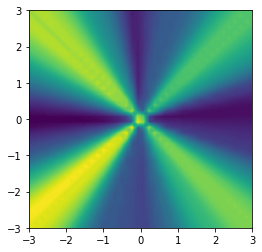

In [66]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(X,Y,mean_ntk.reshape(-1, 40), levels=100)

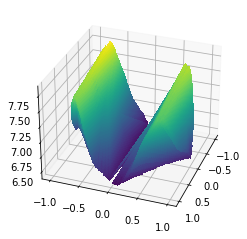

In [71]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.remove()
ax = plt.axes(projection='3d')
plt.contourf(X_norm[:,0].reshape(-1,20),X_norm[:,1].reshape(-1,20),mean_ntk.reshape(-1, 20), levels=100)
ax.view_init(30, 20)


In [70]:
lpk = (
    ConstantKernel(
        constant_value=gp.kernel_.get_params()['k1__k1__constant_value'],
        constant_value_bounds='fixed'
    ) *
    Matern(
        nu=1/2,
        # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
        length_scale=1,
        length_scale_bounds='fixed'
    ) + 
    WhiteKernel(noise_level=gp.kernel_.get_params()['k2__noise_level'], noise_level_bounds='fixed')
)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

ell_lpk = optimize.minimize_scalar(g, args=(
    gp_lpk, mean_ntk, data), 
    method='bounded', bounds=[0.0001, 1], options={'maxiter': 10000})
# for i in range(0, 10):
#     tmp = optimize.minimize_scalar(g, args=(
#         gp_lpk, mean_ntk, data),
#         method='bounded', bounds=[0.0001, 10*(10**i)], options={'maxiter': 10000})
#     if tmp.fun < ell_lpk.fun:
#         ell_lpk = tmp

try:
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
except:
    gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})

gp_lpk.fit(X_norm_train, y_train_noisy)
mean_lpk = gp_lpk.predict(X_norm)

print(gp_lpk.kernel_)
# plt.contourf(X, Y, mean_lpk.reshape(-1, arrsize), levels=100)

0.496**2 * Matern(length_scale=0.0037, nu=0.5) + WhiteKernel(noise_level=0.931)


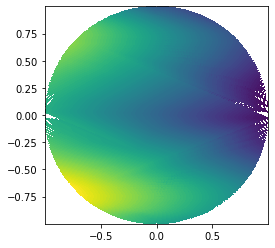

In [68]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(X_norm[:,0].reshape(-1,20),X_norm[:,1].reshape(-1,20),mean_lpk.reshape(-1, 20), levels=100)

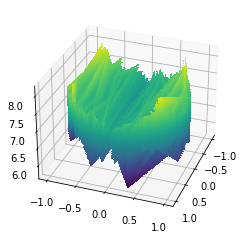

In [72]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.remove()
ax = plt.axes(projection='3d')
plt.contourf(X_norm[:,0].reshape(-1,20),X_norm[:,1].reshape(-1,20),mean_lpk.reshape(-1, 20), levels=100)
ax.view_init(30, 20)

In [73]:
np.corrcoef((mean_ntk)[:,0], (mean_lpk)[:,0])[0, 1]

3.8962730893944436e-01

In [ ]:
gp.kernel_

In [ ]:
plt.scatter(smolY - mean_ntk, smolY - mean_lpk)

In [3]:
sampler = qmc.LatinHypercube(d=2, seed=439)
sample = sampler.random(1000)
sample = qmc.scale(sample, (0, 0), (7, 7))

In [4]:
test = sampler.random(1000)
test = qmc.scale(test, (0, 0), (7, 7))

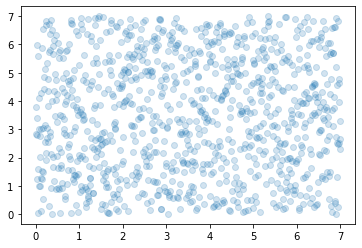

In [5]:
plt.scatter(sample[:,0], sample[:,1], alpha=0.2)

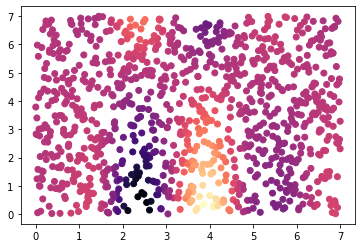

In [6]:
X_lhs, Y_lhs = sample[:,0], sample[:,1]
Z = np.random.normal(np.exp(-X_lhs)*X_lhs**3*np.cos(X_lhs)*np.sin(X_lhs)*(np.cos(X_lhs)*np.sin(X_lhs)**2-1)*(Y_lhs-5), 0.0)
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(X_lhs, Y_lhs, Z_noisy, c=Z_noisy, cmap='magma', alpha=0.5)
plt.scatter(X_lhs, Y_lhs, c=Z, cmap='magma')
dataset = processing(sample, Z)

In [7]:
X_lhs_norm = dataset['norm'][0]
y_lhs = dataset['orig'][1]
X_train_lhs_norm = dataset['norm train'][0]
y_lhs_train = dataset['orig train'][1]

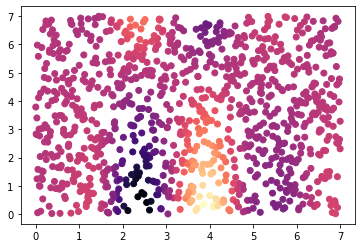

In [10]:
ntk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    NTK(depth=1, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e3)
    ) 
) #+ WhiteKernel(noise_level=1e-7, noise_level_bounds=(1e-10, 1e-2))

gp = GPR(kernel=ntk, alpha=1e-9, n_restarts_optimizer=0, normalize_y=True)
gp.fit(sample, Z)
mean = gp.predict(sample)

plt.scatter(sample[:,0], sample[:,1], c=mean.reshape(-1, 1000), cmap='magma')

Text(0.5, 1.0, 'Shift 0.01')

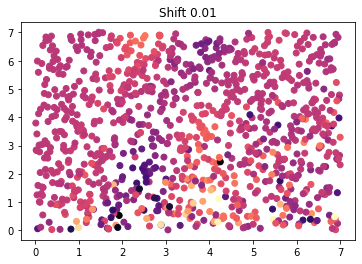

In [12]:
shift = 0.01
mean = gp.predict(sample+shift)

plt.scatter(sample[:,0]+shift, sample[:,1]+shift, c=mean.reshape(-1, 1000), cmap='magma')
plt.title(f'Shift {shift}')

Text(0.5, 1.0, 'Shift 0.001')

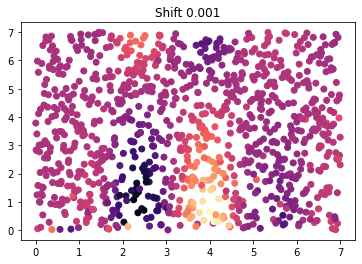

In [13]:
shift = 0.001
mean = gp.predict(sample+shift)

plt.scatter(sample[:,0]+shift, sample[:,1]+shift, c=mean.reshape(-1, 1000), cmap='magma')
plt.title(f'Shift {shift}')

Text(0.5, 1.0, 'Shift 0.0001')

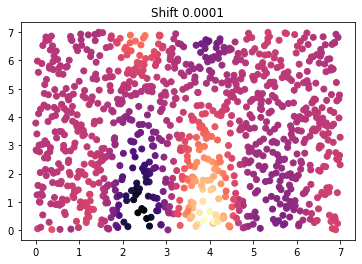

In [14]:
shift = 0.0001
mean = gp.predict(sample+shift)

plt.scatter(sample[:,0]+shift, sample[:,1]+shift, c=mean.reshape(-1, 1000), cmap='magma')
plt.title(f'Shift {shift}')

In [16]:
bigX.shape, sample.shape

((4225, 2), (1000, 2))

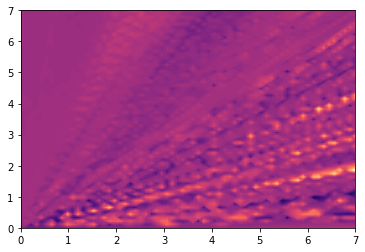

In [22]:
mean = gp.predict(bigX)

plt.contourf(bigX[:,0].reshape(-1, arrsize), bigX[:,1].reshape(-1, arrsize), mean.reshape(-1, arrsize), levels=100, cmap='magma')

In [31]:
ntk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    NTK(depth=1, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e3)
    ) 
)

gp = GPR(kernel=ntk, alpha=1e-9, n_restarts_optimizer=0, normalize_y=True)
gp.fit(X_lhs_norm, y_lhs)
meanntk = gp.predict(bigX_norm)

# # plt.scatter(test[:,0], test[:,1], c=meanntk.reshape(-1, 1000), cmap='magma')

/home/rona1das/Tools/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


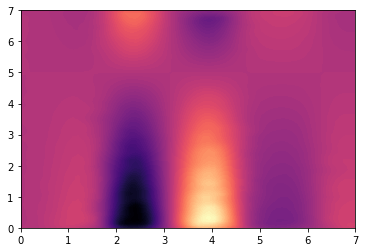

In [34]:
lpk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    Matern(
        nu=1/2,
        length_scale=np.array([1,1]),
        length_scale_bounds=(1e-1, 1e3), 
    ) 
)

gp = GPR(kernel=lpk, alpha=1e-9, n_restarts_optimizer=0, normalize_y=True)
gp.fit(sample, Z)
mean = gp.predict(bigX)

plt.contourf(bigX[:,0].reshape(-1, arrsize), bigX[:,1].reshape(-1, arrsize), mean.reshape(-1, arrsize), levels=100, cmap='magma')

In [49]:
type(gp.get_params()['kernel__k2__length_scale'])

numpy.ndarray

In [25]:
y_lhs.shape

(1000, 1)

In [26]:
def g(ell, gp, residual, p_or_s = 'p'):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})
    
    gp.fit(X_lhs_norm, y_lhs)
    mean = gp.predict(bigX_norm)

    if p_or_s == 's':
        return -spearmanr(residual,smolY-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (smolY-mean)[:,0])[0, 1]

In [27]:
lpk = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e5)
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp = GPR(kernel=lpk, alpha=1e-9, n_restarts_optimizer=0, normalize_y=True)
ell_lpk = optimize.minimize_scalar(g, args=(gp, smolY-meanntk, 'p'), method='bounded', bounds=[0.00001, 10], options={'maxiter' : 10000})
for i in range(0, 10):
    tmp = optimize.minimize_scalar(g, args=(gp, smolY-meanntk, 'p'), method='bounded', bounds=[0.00001, 10*(10**i)], options={'maxiter' : 10000})
    if tmp.fun < ell_lpk.fun:
        ell_lpk = tmp 

gp.set_params(**{'kernel__k2__length_scale': ell_lpk})
# gp.fit(X_lhs_norm, y_lhs)
meanlpk = gp.predict(bigX_norm)

# plt.contourf(X, Y, mean.reshape(-1, arrsize), levels=100, cmap='magma')

/home/rona1das/Tools/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

In [45]:
meanntk.shape, meanlpk.shape, smolY.shape

((4225, 2), (4225, 2), (4225, 1))

In [28]:
np.corrcoef((smolY - meanntk)[:,0], (smolY-meanlpk)[:,0])[0, 1], spearmanr(smolY - meanntk, smolY-meanlpk)[0]

(0.711449887138964, 0.6910167617841748)

In [32]:
smolY.shape

(4225, 1)

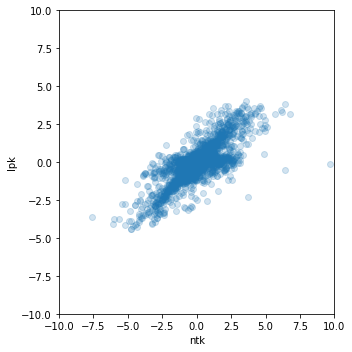

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(smolY - meanntk, smolY-meanlpk, alpha=0.2)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_xlabel('ntk')
ax.set_ylabel('lpk')
fig.tight_layout()